In [1]:
from keras.utils import to_categorical
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
plt.close()

# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = './training/'
dir_test_images   = './testing/'
dir_train_labels  = './labels_training.csv'
dir_test_ids      = './sample_submission.csv'

In [3]:
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

In [4]:
data, y_binary = load_data(dir_train_images, dir_train_labels, training=True)

test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)

img_rows, img_cols = 101, 101

data = data.astype('float32')
data /= 255

test_data = test_data.astype('float32')
test_data /= 255

input_shape = img_rows, img_cols, 3

In [5]:
train_data, validation_data, train_label, validation_label = train_test_split(data, y_binary, test_size=100, random_state=114)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = input_shape, activation = 'relu', padding = 'same'))

# Step 2 - Pooling
#classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))
#classifier.add(Dropout(0.2))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
#classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))
#classifier.add(Dropout(0.2)) 

# Adding a third convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu', strides = (2,2)))
#classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))
#classifier.add(Dropout(0.5))

# Adding a fourth convolutional layer
classifier.add(Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
#classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

# Adding a fifth convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
#classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

classifier.compile(loss=keras.losses.binary_crossentropy,
          optimizer=keras.optimizers.Adam(),
          metrics=['accuracy'])

In [7]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 101, 101, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 256)        

In [8]:
history4 = classifier.fit(
    data, 
    y_binary,
    batch_size=100,
    epochs=50,
    verbose=1,
    validation_data=(validation_data, validation_label))

Train on 1500 samples, validate on 100 samples
Epoch 1/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.6554 - accuracy: 0.6607 - val_loss: 0.6730 - val_accuracy: 0.6200
Epoch 2/50
1500/1500 [==============================] - 1s 766us/step - loss: 0.6496 - accuracy: 0.6633 - val_loss: 0.6687 - val_accuracy: 0.6200
Epoch 3/50
1500/1500 [==============================] - 1s 767us/step - loss: 0.6488 - accuracy: 0.6633 - val_loss: 0.6708 - val_accuracy: 0.6200
Epoch 4/50
1500/1500 [==============================] - 1s 764us/step - loss: 0.6462 - accuracy: 0.6633 - val_loss: 0.6647 - val_accuracy: 0.6200
Epoch 5/50
1500/1500 [==============================] - 1s 778us/step - loss: 0.6410 - accuracy: 0.6633 - val_loss: 0.6626 - val_accuracy: 0.6200
Epoch 6/50
1500/1500 [==============================] - 1s 754us/step - loss: 0.6387 - accuracy: 0.6633 - val_loss: 0.6592 - val_accuracy: 0.6200
Epoch 7/50
1500/1500 [==============================] - 1s 758us/step - loss: 0

In [9]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=90, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)

batches = gen.flow(data, y_binary, batch_size=100)
validation_batches = gen.flow(validation_data, validation_label, batch_size=100)

history4 = classifier.fit_generator(batches, epochs=150, validation_data=validation_batches)

Epoch 1/150
15/15 [==============================] - 4s 294ms/step - loss: 0.7612 - accuracy: 0.6913 - val_loss: 0.6424 - val_accuracy: 0.6200
Epoch 2/150
15/15 [==============================] - 5s 301ms/step - loss: 0.6144 - accuracy: 0.6547 - val_loss: 0.6615 - val_accuracy: 0.6100
Epoch 3/150
15/15 [==============================] - 5s 317ms/step - loss: 0.6169 - accuracy: 0.6693 - val_loss: 0.5902 - val_accuracy: 0.6200
Epoch 4/150
15/15 [==============================] - 5s 303ms/step - loss: 0.5667 - accuracy: 0.6973 - val_loss: 0.4857 - val_accuracy: 0.7600
Epoch 5/150
15/15 [==============================] - 5s 322ms/step - loss: 0.5005 - accuracy: 0.7693 - val_loss: 0.4624 - val_accuracy: 0.8100
Epoch 6/150
15/15 [==============================] - 6s 370ms/step - loss: 0.4998 - accuracy: 0.7813 - val_loss: 0.4470 - val_accuracy: 0.8000
Epoch 7/150
15/15 [==============================] - 5s 307ms/step - loss: 0.4389 - accuracy: 0.7947 - val_loss: 0.4131 - val_accuracy: 0.8200

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import pandas
import numpy
import warnings
warnings.filterwarnings("ignore")
import sklearn.metrics as metrics

In [11]:
def plot_roc(labels, prediction_scores, title='ROC'):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
       
    plt.figure(figsize=(10,8))
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string, color = 'red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.axis('square')
    plt.title(title)
    plt.legend()
    plt.tight_layout()

In [12]:
r = classifier.predict(data)

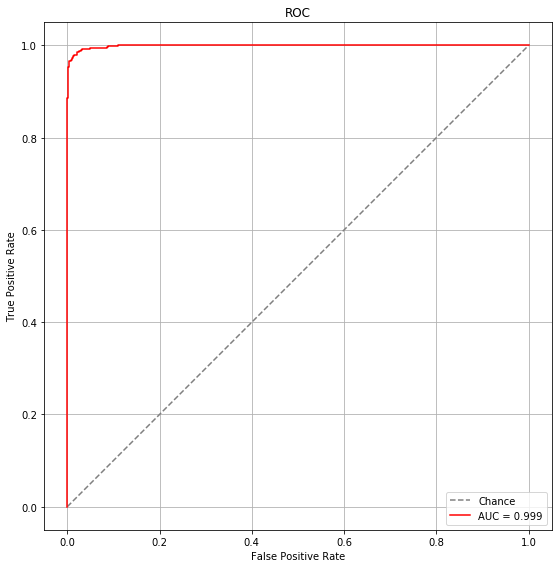

In [13]:
plot_roc(y_binary, r)

In [14]:
import numpy
numpy.mean(r)

0.31125817

In [15]:
r

array([[1.7929992e-04],
       [1.2487938e-03],
       [9.3217587e-01],
       ...,
       [8.1225317e-06],
       [3.2924474e-03],
       [9.9809128e-01]], dtype=float32)

In [16]:
y_binary

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [17]:
numpy.mean(y_binary)

0.33666666666666667

In [18]:
numpy.sum(numpy.abs((r>0.5).reshape((1500,)) - y_binary)) / 1500

0.025333333333333333

In [19]:
produce_submission = True # Switch this to True when you're ready to create a submission for Kaggle

test_scores    = classifier.predict(test_data)
test_scores = test_scores.reshape((test_scores.shape[0],))
# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids,
                               'score':  test_scores})

In [20]:
if produce_submission:
    submission_file.to_csv('yyf_strides_cnn_5_layers.csv',
                           columns=['id','score'],
                           index=False)

In [21]:
submission_file.head()

,id,score
0,1500,0.000597
1,1501,0.000044
2,1502,0.879288
3,1503,0.000242
4,1504,0.000143


In [22]:
submission_file[submission_file['id']==1923]

,id,score
423,1923,0.255201


In [23]:
npmat=submission_file.values

In [24]:
npmat[npmat[:,0]==1923,:]

array([[1.92300000e+03, 2.55200714e-01]])